In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.0.0
Torchvision Version:  0.2.1


In [2]:
# Top level data directory. Here we assume the format of the directory conforms
# to the ImageFolder structure
data_dir = "E:/data/dataset_updated/"

# Number of classes in the dataset
num_classes = 5

model_name = 'resnet'

# Batch size for training (change depending on how much memory you have)
batch_size = 7

# Number of epochs to train for
num_epochs = 30

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


### Using Pre-trained Network as Feature Extractor

We use ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet'] as feature extractor and train the final layer for a 7 class classification task. We finally plot the validation accuracies obtained from all the five pre-trained networks over 20 epochs. 

In [7]:
## basically, we loop through each model in the model_list

model_list = ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet']
acc_history = {}
for model_name in model_list:
    # Initialize the non-pretrained version of the model used for this run
    model,_ = initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    _, acc_history[model_name] = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))


Epoch 0/29
----------
train Loss: 0.6233 Acc: 0.7805
val Loss: 0.3273 Acc: 0.8703

Epoch 1/29
----------
train Loss: 0.4459 Acc: 0.8389
val Loss: 0.2988 Acc: 0.8937

Epoch 2/29
----------
train Loss: 0.4336 Acc: 0.8425
val Loss: 0.2939 Acc: 0.8750

Epoch 3/29
----------
train Loss: 0.4189 Acc: 0.8467
val Loss: 0.2943 Acc: 0.8902

Epoch 4/29
----------
train Loss: 0.4063 Acc: 0.8483
val Loss: 0.2667 Acc: 0.8984

Epoch 5/29
----------
train Loss: 0.4329 Acc: 0.8395
val Loss: 0.2723 Acc: 0.8925

Epoch 6/29
----------
train Loss: 0.3925 Acc: 0.8540
val Loss: 0.2520 Acc: 0.8949

Epoch 7/29
----------
train Loss: 0.4052 Acc: 0.8513
val Loss: 0.2556 Acc: 0.8937

Epoch 8/29
----------
train Loss: 0.4044 Acc: 0.8491
val Loss: 0.2591 Acc: 0.8960

Epoch 9/29
----------
train Loss: 0.3807 Acc: 0.8630
val Loss: 0.2937 Acc: 0.8902

Epoch 10/29
----------
train Loss: 0.3890 Acc: 0.8592
val Loss: 0.3252 Acc: 0.8879

Epoch 11/29
----------
train Loss: 0.4170 Acc: 0.8467
val Loss: 0.2780 Acc: 0.8914

Ep

C:\Users\Parth Pankaj Tiwary\Anaconda2\envs\torch\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
C:\Users\Parth Pankaj Tiwary\Anaconda2\envs\torch\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


Epoch 0/29
----------
train Loss: 0.4597 Acc: 0.8360
val Loss: 0.2958 Acc: 0.8867

Epoch 1/29
----------
train Loss: 0.3182 Acc: 0.8840
val Loss: 0.2717 Acc: 0.9054

Epoch 2/29
----------
train Loss: 0.2840 Acc: 0.8976
val Loss: 0.2588 Acc: 0.9124

Epoch 3/29
----------
train Loss: 0.2981 Acc: 0.8915
val Loss: 0.2485 Acc: 0.9264

Epoch 4/29
----------
train Loss: 0.2766 Acc: 0.8982
val Loss: 0.2803 Acc: 0.8937

Epoch 5/29
----------
train Loss: 0.2745 Acc: 0.8969
val Loss: 0.2404 Acc: 0.9100

Epoch 6/29
----------
train Loss: 0.2740 Acc: 0.8983
val Loss: 0.2255 Acc: 0.9217

Epoch 7/29
----------
train Loss: 0.2604 Acc: 0.8991
val Loss: 0.2244 Acc: 0.9124

Epoch 8/29
----------
train Loss: 0.2612 Acc: 0.9034
val Loss: 0.2461 Acc: 0.9206

Epoch 9/29
----------
train Loss: 0.2628 Acc: 0.9022
val Loss: 0.2388 Acc: 0.9100

Epoch 10/29
----------
train Loss: 0.2570 Acc: 0.9082
val Loss: 0.2728 Acc: 0.9217

Epoch 11/29
----------
train Loss: 0.2508 Acc: 0.9030
val Loss: 0.2397 Acc: 0.9241

Ep

C:\Users\Parth Pankaj Tiwary\Anaconda2\envs\torch\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Epoch 0/29
----------
train Loss: 0.5911 Acc: 0.7974
val Loss: 0.3016 Acc: 0.9019

Epoch 1/29
----------
train Loss: 0.4018 Acc: 0.8566
val Loss: 0.2537 Acc: 0.9112

Epoch 2/29
----------
train Loss: 0.3932 Acc: 0.8566
val Loss: 0.2357 Acc: 0.9194

Epoch 3/29
----------
train Loss: 0.3709 Acc: 0.8666
val Loss: 0.2544 Acc: 0.9159

Epoch 4/29
----------
train Loss: 0.3627 Acc: 0.8661
val Loss: 0.2247 Acc: 0.9229

Epoch 5/29
----------
train Loss: 0.3608 Acc: 0.8679
val Loss: 0.2192 Acc: 0.9217

Epoch 6/29
----------
train Loss: 0.3609 Acc: 0.8671
val Loss: 0.2417 Acc: 0.9100

Epoch 7/29
----------
train Loss: 0.3542 Acc: 0.8735
val Loss: 0.2011 Acc: 0.9322

Epoch 8/29
----------
train Loss: 0.3300 Acc: 0.8808
val Loss: 0.1991 Acc: 0.9241

Epoch 9/29
----------
train Loss: 0.3495 Acc: 0.8679
val Loss: 0.2215 Acc: 0.9206

Epoch 10/29
----------
train Loss: 0.3406 Acc: 0.8755
val Loss: 0.1945 Acc: 0.9276

Epoch 11/29
----------
train Loss: 0.3371 Acc: 0.8814
val Loss: 0.2241 Acc: 0.9136

Ep

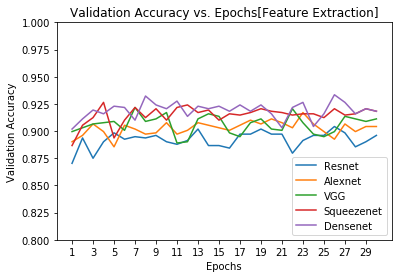

In [46]:
# Plot the training curves of validation accuracy vs. number
# of training epochs for the transfer learning method and
# the model trained from scratch
resnet = []
alexnet = []
vgg = []
squeezenet = []
densenet = []

resnet = [h.cpu().numpy() for h in acc_history['resnet']]
alexnet = [h.cpu().numpy() for h in acc_history['alexnet']]
vgg = [h.cpu().numpy() for h in acc_history['vgg']]
squeezenet = [h.cpu().numpy() for h in acc_history['squeezenet']]
densenet = [h.cpu().numpy() for h in acc_history['densenet']]

plt.title("Validation Accuracy vs. Epochs[Feature Extraction]")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),resnet,label="Resnet")
plt.plot(range(1,num_epochs+1),alexnet,label="Alexnet")
plt.plot(range(1,num_epochs+1),vgg,label="VGG")
plt.plot(range(1,num_epochs+1),squeezenet,label="Squeezenet")
plt.plot(range(1,num_epochs+1),densenet,label="Densenet")
# plt.plot(range(1,num_epochs+1),inception,label="Inception")
plt.ylim((0.8, 1.))
plt.xticks(np.arange(1, num_epochs + 1, 2.0))
plt.legend()
plt.savefig("feature_extractor_zoomed_in.jpg", bbox_inches='tight')
plt.show()


In [31]:
plt.savefig("feature_extractor.jpg", bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

### Training Pre-trained Network from Scratch

We use ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet'] and train them from scratch for a 7 class classification task. We finally plot the validation accuracies obtained from all the five pre-trained networks over 20 epochs. 

In [7]:
torch.cuda.empty_cache()

In [8]:
## basically, we loop through each model in the model_list

model_list = ['resnet', 'alexnet']
acc_history_scratch = {}
for model_name in model_list:
    # Initialize the non-pretrained version of the model used for this run
    model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    _, acc_history_scratch[model_name] = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    torch.cuda.empty_cache() 

Epoch 0/29
----------
train Loss: 1.0954 Acc: 0.5822
val Loss: 0.6812 Acc: 0.7582

Epoch 1/29
----------
train Loss: 0.9496 Acc: 0.6507
val Loss: 0.6426 Acc: 0.7745

Epoch 2/29
----------
train Loss: 0.8658 Acc: 0.6873
val Loss: 0.6074 Acc: 0.7886

Epoch 3/29
----------
train Loss: 0.8186 Acc: 0.7051
val Loss: 0.6671 Acc: 0.7640

Epoch 4/29
----------
train Loss: 0.7629 Acc: 0.7179
val Loss: 0.5779 Acc: 0.7932

Epoch 5/29
----------
train Loss: 0.7049 Acc: 0.7428
val Loss: 0.5588 Acc: 0.8037

Epoch 6/29
----------
train Loss: 0.6762 Acc: 0.7574
val Loss: 0.5819 Acc: 0.8061

Epoch 7/29
----------
train Loss: 0.6766 Acc: 0.7565
val Loss: 0.5055 Acc: 0.8248

Epoch 8/29
----------
train Loss: 0.6476 Acc: 0.7665
val Loss: 0.6565 Acc: 0.7769

Epoch 9/29
----------
train Loss: 0.6140 Acc: 0.7822
val Loss: 0.4952 Acc: 0.8271

Epoch 10/29
----------
train Loss: 0.6025 Acc: 0.7834
val Loss: 0.4760 Acc: 0.8388

Epoch 11/29
----------
train Loss: 0.5797 Acc: 0.7917
val Loss: 0.5318 Acc: 0.8201

Ep

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 3.00 GiB total capacity; 1.80 GiB already allocated; 211.49 MiB free; 60.89 MiB cached)

In [ ]:
model_list = ['vgg', 'squeezenet', 'densenet']
acc_history_scratch = {}
for model_name in model_list:
    # Initialize the non-pretrained version of the model used for this run
    model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    _, acc_history_scratch[model_name] = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    torch.cuda.empty_cache() 

In [ ]:
# Plot the training curves of validation accuracy vs. number
# of training epochs for the transfer learning method and
# the model trained from scratch
resnet = []
alexnet = []
vgg = []
squeezenet = []
densenet = []

resnet = [h.cpu().numpy() for h in acc_history_scratch['resnet']]
alexnet = [h.cpu().numpy() for h in acc_history_scratch['alexnet']]
vgg = [h.cpu().numpy() for h in acc_history_scratch['vgg']]
squeezenet = [h.cpu().numpy() for h in acc_history_scratch['squeezenet']]
densenet = [h.cpu().numpy() for h in acc_history_scratch['densenet']]

plt.title("Validation Accuracy vs. Epochs[Scratch]")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),resnet,label="Resnet")
plt.plot(range(1,num_epochs+1),alexnet,label="Alexnet")
plt.plot(range(1,num_epochs+1),vgg,label="VGG")
plt.plot(range(1,num_epochs+1),squeezenet,label="Squeezenet")
plt.plot(range(1,num_epochs+1),densenet,label="Densenet")
# plt.plot(range(1,num_epochs+1),inception,label="Inception")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs + 1, 2.0))
plt.legend()
lt.savefig("scratch_training.jpg", bbox_inches='tight')
plt.show()